<center><h1>Graph project: Epidemic spreading</h1></center>

<center><h3>FARAH Othmane </h3></center>

<div style="width:75%;margin:0 auto;">
    
## Introduction
<a id='intro'></a>
    
<p style="text-align:justify;"> As you know, a new epidemic has overwhelmed the world, COVID-19 jeopardizes people and changes our habits. It is easy to realise that knowing how illnesses spread is vital to our own protection. How can we predict whether a disease will cause an epidemic, how many people it will infect, which people it will infect, and whether or not it is dangerous to society as a whole ? Also, how can we determine which techniques to use in fighting an epidemic once it begins ? One way to answer all of these questions is through <strong>mathematical modeling</strong>. </p>

<p style="text-align:justify;"> In this work you will have to review different epidemic modelings relying all on the representation by graphs of a human network called a <strong>contact network</strong>. A vertex in a contact network represents an individual and an edge between two vertices represents a contact between two individuals. The disease only spread from individual to individual if they are in contact, so through the edges. This representation is actually really common in research, and a lot of state-of-the-art modeling are built over it. From these different models you will be asked to draw conclusions from experiments on varying contact networks</p>


<div style="width:75%;margin:0 auto;">

## Environment and packages installation
<a id='env'></a>
    

In [178]:
"""import Pkg
Pkg.add("LightGraphs")
Pkg.add("GraphPlot")
Pkg.add("Colors")
Pkg.add("CairoMakie")
Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add("JLD2")
Pkg.add("Compose")"""
# Import packages
using LightGraphs
using GraphPlot
using Colors
using CairoMakie
using StatsBase
using Plots
using JLD2
using Compose

<div style="width:75%;margin:0 auto;">

## Part 1 - SIS model
<a id='part1'></a>

<p style="text-align:justify;">SIS is a compartmental model, ie a model where the population is divided into subgroups that represent the disease status of its members. SIS stands for Susceptible $\rightarrow$ Infected $\rightarrow$ Susceptible where the susceptible group contains those who remain susceptible to the infection, and the infected group consists of those who not only have the disease but are also in the contagious period of the disease.</p>
    
<p style="text-align:justify;"> Combine with a contact network approach, this model can capture contact patterns (family, company, friends). Each vertex represents an individual in the host population, and contacts between two individuals are represented by an edge that connects the two. The probability of transmitting the disease from an infected to a susceptible individual along one of these edges or contacts is $\beta$ (=<strong>infection rate</strong>). The probability to cure is $\alpha$ (= <strong>curing rate</strong>). </p>

    
<p style="text-align:justify;">In order for a disease to begin spreading through a network, the disease must be introduced into the population, either through infecting a proportion of the population or through infecting one individual. As time moves forward, the disease will spread away from those initially infected, and two things may occur simultaneously at each time step $t$. First, each infected individual will spread disease to each of its contacts with a probability $\beta$. Secondly, each infectious individual will recover at a rate, $\alpha$ , at which point the individual will then no longer infect any of its contacts. After the disease has run its course, we can determine how the disease affected the network by calculating various quantities that help us better understand the outbreak.
</p>

<br>
    
<p style="font-size:0.9em">P. Van Mieghem, J. Omic, R. E. Kooij, <em>“Virus Spread in Networks”</em>,
IEEE/ACM Transaction on Networking (2009)<p>


<!---
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font size = 4.5px><b>Algorithm 1:</b> Girvan Newman</font><br>
    <div style="margin-left:50px;border-left:2px solid black;padding-left:10px;">
    <b> WHILE </b> there are still edges<b> OR </b> desired nb of communities unreached <b>DO</b>
        <div style="margin-left:50px;border-left:2px solid black;padding-left:10px;">
        Calculate betweeness of all edges <br>
        Remove the edge with the highest betweeness <br>
        Calculate the number of strongly connected components
        </div>
    <b> END WHILE </b>   
    </div>
</div>
--->

<div style="width:75%;margin:0 auto;">

### 1.1 Contact networks sample

In [179]:
"""karat7: A graph representing the karate club of N7 and the connections between the persons in this club.
There are 34 people in this network. It is actually inspired by one of the most famous problem in graph
theory: the Zachary's karate club.
"""
karat7 = smallgraph(:karate)
nodecolor = [colorant"lightseagreen"]
draw(PNG("karat7.png", 100cm, 100cm), gplot(karat7,nodefillc=nodecolor))

In [180]:
"""n7_2A: A graph representing the second year students at N7. Each department (SN, MF2E, 3EA) form a 
community where connections are denser, connections between department are rarer.
"""
c=[[10,0,0] [0.1,10,0] [0.1,0.1,10]]
n=[100,70,50]
n7_2A = stochastic_block_model(c,n)
nodecolor = [colorant"lightseagreen"]
draw(PNG("n7_2A.png", 100cm, 100cm), gplot(n7_2A,nodefillc=nodecolor))

In [181]:
"""toulouse_neigh: A graph representing a neighborhood composed of 1000 people in Toulouse.
"""
toulouse_neigh = barabasi_albert(1000, 1)
nodecolor = [colorant"lightseagreen"]
draw(PNG("toulouse_neigh.png", 100cm, 100cm), gplot(toulouse_neigh,nodefillc=nodecolor))

<div style="width:75%;margin:0 auto;">
  
### 1.2 Introduce the infection
    
<p style="text-align:justify;">We denote by <code>state</code> a vector containing the disease status of each vertex where Susceptible=0 and Infected=1. Then <code>state</code> is an <code>Array{Int32,1}</code> of length the number of vertices. This array in addition of a graph (represented internally by an adjacency matrix or an adjacency list) will be the data structure of our model.</p>
    
<span style="font-size:0.9em">In <code>Array{Int32,1}</code>, <code>Int32</code> refers to the kind of data in the array, here 32 bits integers, <code>1</code> refers to the dimension of the array, here we have a 1-dimensional structure so a vector.</span>

<div style="width:75%;margin:0 auto;">

<strong style="color:cornflowerblue">Question 1 (code):</strong> For each graph in the graph sample (<code>karat7</code>, <code>n7_2A</code>, <code>toulouse_neigh</code>) initialize the state array by assigning each vertex to susceptible and add randomly one or numerous infected people. Save the graph as a .png image using <code>gplot</code> and <code>draw</code>, infected should appear in a different color (<code>colorant"orange"</code>).
    
Due to a bug on certain version of Jupyter Notebook, the graph <span style="font-size:1.3em">figures should be saved in a file and not plot inside the notebook </span> !!!
    
Gplot GitHub: https://github.com/JuliaGraphs/GraphPlot.jl
    
Gplot examples: https://juliagraphs.org/GraphPlot.jl/

In [182]:
# Infect Karat7
karat7_nv = nv(karat7)
karat7_state = zeros(Int, karat7_nv)
# nombre de personnes infectes
N = 10
for i = 1:N
    karat7_state[rand(1:karat7_nv)] = 1
end
karat7_state
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[karat7_state.+1]
draw(PNG("new_karat7.png", 100cm, 100cm), gplot(karat7,nodefillc=nodefillc))

In [183]:
# Infect N7_2A
n7_2A_nv = nv(n7_2A)
n7_2A_state = zeros(Int, n7_2A_nv)

# nombre de personnes infectes
N = 10

for i = 1:N
    n7_2A_state[rand(1:n7_2A_nv)] = 1
end
n7_2A_state
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[n7_2A_state.+1]
draw(PNG("new_n7_2A.png", 100cm, 100cm), gplot(n7_2A,nodefillc=nodefillc))

In [184]:
# Infect Toulouse_neigh
toulouse_neigh_nv = nv(toulouse_neigh)
toulouse_neigh_state = zeros(Int, toulouse_neigh_nv)

# nombre de personnes infectes
N = 10

for i = 1:N
    toulouse_neigh_state[rand(1:toulouse_neigh_nv)] = 1
end
toulouse_neigh_state
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[toulouse_neigh_state.+1]
draw(PNG("new_toulouse_neigh.png", 100cm, 100cm), gplot(toulouse_neigh,nodefillc=nodefillc))

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 2 (written):</strong> What do you think/predict about the influence of the initial number of infected people and their locations on the evolution of an SIS model epidemic ?

<br>
    
<div style="background-color:#E7F1D1"><strong>Answer:</strong>
    Dans ce modèle, plus le nombre initial de personnes infectées est important, plus l'épidémie va se propager plus vite vu que plus de personnes pourront infecter leur voisin.
    Et si les personnes infectées sont dans des zones denses, l'épidémie va se propager plus vite car une zone dense signifie que la personne aura beaucoup de voisins à infecter.
</div>

<div style="width:75%;margin:0 auto;">
  
### 1.3 Spread the infection

<div style="width:75%;margin:0 auto;">
      
<strong style="color:cornflowerblue">Question 3 (code):</strong> Implement the <code>function SIS</code> (respect the header and the specifications). You can use <code>rand</code> to translate the probabilities. Test your algorithm on <code>karat7</code>, <code>n7_2A</code>, and <code>toulouse_neigh</code> with arbitrary $\beta$, $\alpha$, and $t$.
    
<span style="font-size:0.9em">The corrector should be able to write <code>new_state = SIS(net,state,beta,alpha,t)</code> with your code.</span>

In [185]:
function SIS(net,state,beta,alpha,t)
    """Take a contact network at a certain state and apply t time steps
    of an SIS model.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       state (Array{Int32,1}): disease status of each vertex
       beta (Float64): infection rate
       alpha (Float64): curing rate
       t (Int32): number of time step
    
    RETURNS
        (Array{Int32,1}): The new state of the contact network after t time steps.
    """ 
    new_state = copy(state)
    for i in 1:t
        for j in 1:nv(net)
            if state[j] == 1 
                neigh = all_neighbors(net, j)
                for ind in neigh
                    if (state[ind] == 0)
                    r = rand()
                    if r < beta
                        new_state[ind] = 1
                    end
                    end
                end
                r = rand()
                if r < alpha
                    if (state[j] == 1)
                    new_state[j] = 0
                    end
                end
            end  
        end
    end
    return new_state
end

SIS (generic function with 1 method)

In [186]:
# Test on Karat7
new_karat7_state = SIS(karat7, karat7_state, 0.3, 0.1, 10)
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[new_karat7_state.+1]
draw(PNG("Karat7_SIS.png", 100cm, 100cm), gplot(karat7,nodefillc=nodefillc))

In [187]:
# Test on N7_2A
new_n7_2A_state = SIS(n7_2A, n7_2A_state, 0.1, 0.3, 10)
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[new_n7_2A_state.+1]
draw(PNG("n7_2A_SIS.png", 100cm, 100cm), gplot(n7_2A,nodefillc=nodefillc))

In [188]:
# Test on Toulouse_neigh
new_toulouse_neigh_state = SIS(toulouse_neigh, toulouse_neigh_state, 0.1, 0.1, 100)
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[new_toulouse_neigh_state.+1]
draw(PNG("toulouse_neigh_SIS.png", 100cm, 100cm), gplot(toulouse_neigh,nodefillc=nodefillc))

<div style="width:75%;margin:0 auto;">

### 1.4 Simulate and understand the epidemic
    
<p style="text-align:justify;">In the SIS model of this project, every disease is characterized by:
    
* The infection rate $\beta$ representing the chance of infection when being in contact with an infected individual.
* The curing rate $\alpha$ representing the chance of being cured of the disease.
* The effective spreading rate $\tau=\frac{\beta}{\alpha}$ representing the capacity of the disease to spread. More the disease infect easily ($\beta$ high) and less it is cured easily ($\alpha$ low) more $\tau$ can be high.

We are now willing to understand what are the influences of these parameters as well as the contact network shape on an epidemic.</p>

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 4 (written):</strong> The <code>function SIS</code> you implemented launches one run of an SIS model on a given contact network. As it makes use of randomness, one run of spreading is stochastic. Then what simple estimator/method can you propose to provide a prediction of the disease spreading on a given contact network ?
   
<br>
    
<div style="background-color:#E7F1D1"> <Strong>Answer:</Strong>
Si on prend $S(t)$ le nombre de personne susceptibles à un instant t et $I(t)$ le nombre de personne inféctés à l'instant t, l'utilisation du modèle $SIS$ nous permet d'obtenir ces deux équations :
    
<center>$\frac{d S(t)}{dt} = -\beta S(t) I(t) + \alpha I(t)$ et
    $\frac{d I(t)}{dt} = \beta S(t) I(t) - \alpha I(t)$</center>

La résolution de ces deux équations vont nous permettre d'avoir une prédiction sur l'évolution du virus.
</div>


<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 5 (code):</strong> Implement the <code>function Simulation_SIS</code> (respect the header and the specifications).
    
<span style="font-size:0.9em">The corrector should be able to write <code>predictions, taus = Simulation_SIS(net,nbinf,betas,alphas,t,nbsimu)</code> with your code.</span>

In [189]:
function Simulation_SIS(net,nbinf,betas,alphas,t,nbsimu)
    """Take a contact network, different diseases (defined by 
    different parameters alpha and beta), a number of initial
    infected people and process nbsimu simulations of SIS over
    t time steps. You will provide the prediction of the 
    percentage of infected at each time t as well as the 
    spreading rate of each disease.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       nbinf (Int32): number of infected at the start of each 
            simulation
       betas (Array{Float64,1}): array of infection rate on edges
       alphas (Array{Float64,1}): array of curing rate on vertices
       t (Int32): number of time step
       nbsimu (Int32): number of simulations
    
    RETURNS
        (Array{Float64,2}): the prediction of the percentage of 
            infected at each time step and for each disease. The 
            first dimension contains the time steps and the second
            contains the diseases
        (Array{Float64,1}): effective spreading rate for each 
            disease
    """
    # On infecte nbinf individus
    state = zeros(Int, nv(net))
    for i = 1:nbinf
        state[rand(1:nv(net))] = 1
    end
    
    nb_d = length(alphas)
    taus = zeros(nb_d)
    pred = zeros(t,nb_d)

    for l in 1:nbsimu
        for k in 1:nb_d
            # SIS
            new_state = copy(state)
            for i in 1:t
                new_state = SIS(net,new_state,betas[k],alphas[k],1)
                pred[i,k] = (sum(new_state) / length(new_state)) + pred[i,k]  
            end
        end
    end
    for k in 1:nb_d
        for i in 1:t
            pred[i,k] = pred[i,k] / nbsimu
        end
        taus[k] = betas[k] / alphas[k]
    end
    return pred, taus
end

Simulation_SIS (generic function with 1 method)

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 6 (written)</strong>: Run the 2 scripts below and describe what you see. Conclude on the influence of $\tau$, $\beta$, and $\alpha$ on an epidemic we can model with SIS.
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque qu'un $\tau$ plus grand nous donne un pourcentage d'infection plus grand (en comparant par exemple la courbe pour $\tau = 4$ et $\tau = 1$). Si on prend les couples $(\alpha,\beta)$ : $(0.1,0.4)$ et $(0.1,0.05)$, on arrive au pourcentage maximal pour le premier couple plus rapidement, donc un $\beta$ plus grand nous donne une augmentation de nombre d'infection plus rapide. Si on prend maintenant les couples $(\alpha,\beta)$ : $(0.05,0.05)$ et $(0.1,0.05)$, on arrive au pourcentage maximal pour le premier couple plus rapidement, donc un $\alpha$ plus petit nous donne une augmentation de nombre d'infection plus rapide.  </div>

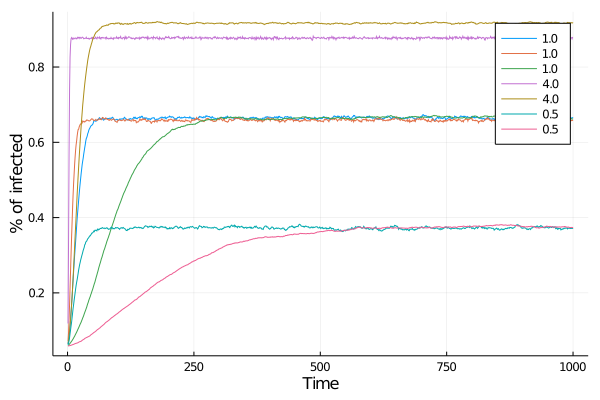

In [190]:
# Script launching predictions on different diseases on karat7 and printing 
# the precentage of infected at each time step.
betas=[0.05,0.1,0.01,0.4,0.04,0.05,0.005]
alphas=[0.05,0.1,0.01,0.1,0.01,0.1,0.01]

predictions, taus = Simulation_SIS(karat7,2,betas,alphas,1000,1000)

Plots.plot(predictions, label=taus',xlabel="Time",ylabel="% of infected")

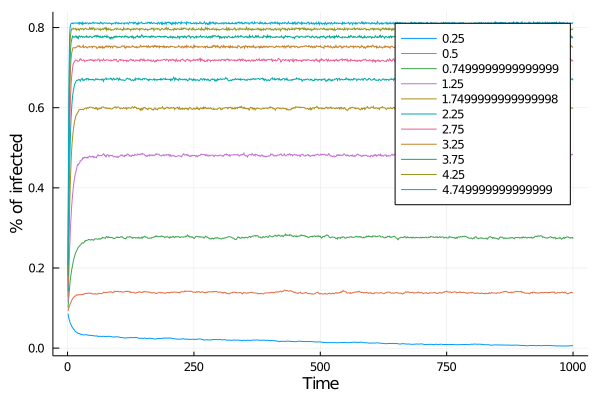

In [191]:
# Same as before but applied on toulouse_neigh. May be a bit long to run.
betas = [0.05,0.1,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
alphas = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]

predictions, taus = Simulation_SIS(toulouse_neigh,100,betas,alphas,1000,100)

Plots.plot(predictions, label=taus',xlabel="Time",ylabel="% of infected")

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 7 (written):</strong> Change the initial number of infected in the scripts above, is it in accordance with your answer in Question 2 ?
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> Oui ce résultat est cohérent avec notre réponse vu que pour un nombre d'infection égal à 8, on obtient des pourcentages d'infections maximaux plus grand qu'avec un nombre d'infection initial égal à 2.</div>

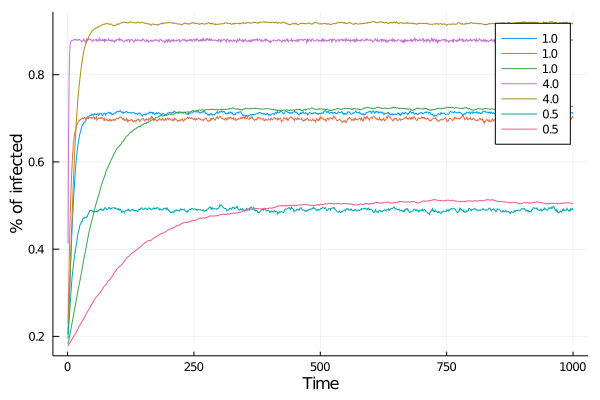

In [192]:
# Change the initial number of infected
# Script launching predictions on different diseases on karat7 and printing 
# the precentage of infected at each time step.
betas=[0.05,0.1,0.01,0.4,0.04,0.05,0.005]
alphas=[0.05,0.1,0.01,0.1,0.01,0.1,0.01]

predictions, taus = Simulation_SIS(karat7,8,betas,alphas,1000,1000)

Plots.plot(predictions, label=taus',xlabel="Time",ylabel="% of infected")

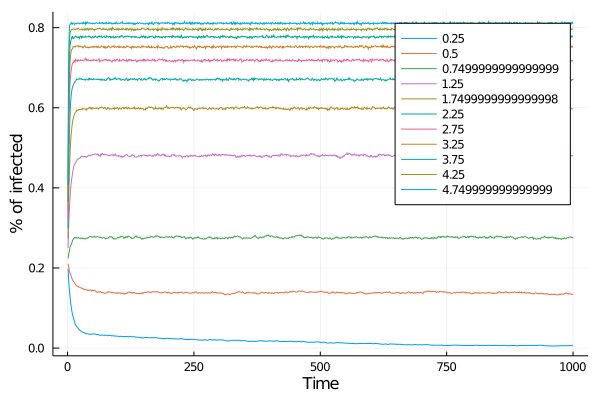

In [193]:
# Same as before but applied on toulouse_neigh. May be a bit long to run.
betas = [0.05,0.1,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
alphas = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]

predictions, taus = Simulation_SIS(toulouse_neigh,250,betas,alphas,1000,100)

Plots.plot(predictions, label=taus',xlabel="Time",ylabel="% of infected")

<div style="width:75%;margin:0 auto;">

<strong style="color:cornflowerblue">Question 8 (code):</strong> Implement a script plotting the maximum percentage of infected people according to $\tau$ over 300 time steps for 3 contact networks:

* A regular graph of 200 vertices with degree 2.
* A regular graph of 200 vertices with degree 5.
* A regular graph of 200 vertices with degree 10.

You can use the function <code>random_regular_graph(n,d)</code> of LighGraphs. As you probably need to use a certain number of different values of $\tau$ to visualize something interesting (the more there are the more the figure will be smooth) you should fix $\alpha$ and make $\beta$ vary. 

<span style="font-size:0.9em">A regular graph is a graph where each vertex has the same degree.</span>

In [194]:
# Plots of the maximum percentage of infected people according to tau over 300 time 
# steps for 3 contact networks.
G2 = random_regular_graph(200,2)
G5 = random_regular_graph(200,5)
G10 = random_regular_graph(200,10)
betas = [0.05,0.1,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
alphas = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]
predictions2, taus2 = Simulation_SIS(G2,3,betas,alphas,300,100)
predictions5, taus5 = Simulation_SIS(G5,3,betas,alphas,300,100)
predictions10, taus10 = Simulation_SIS(G10,3,betas,alphas,300,100)

([0.019149999999999986 0.026649999999999983 … 0.1313 0.145; 0.025299999999999993 0.04359999999999999 … 0.6511499999999999 0.7199500000000001; … ; 0.5110499999999997 0.7249999999999999 … 0.8285000000000001 0.8339000000000002; 0.5082 0.7248 … 0.8351499999999998 0.8364999999999995], [0.25, 0.5, 0.7499999999999999, 1.25, 1.7499999999999998, 2.25, 2.75, 3.25, 3.75, 4.25, 4.749999999999999])

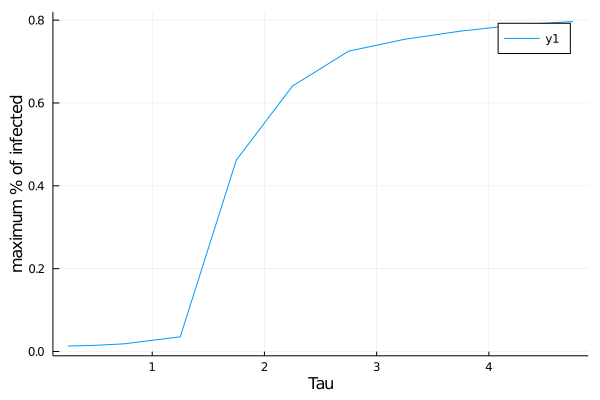

In [195]:
Plots.plot(taus2, maximum(predictions2, dims = 1)', xlabel="Tau",ylabel="maximum % of infected")

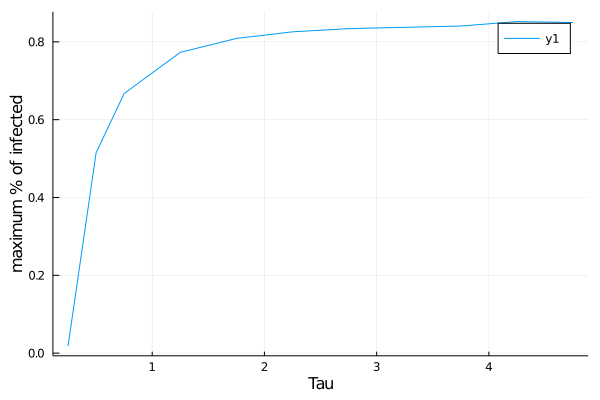

In [196]:
Plots.plot(taus5, maximum(predictions5, dims = 1)', xlabel="Tau",ylabel="maximum % of infected")

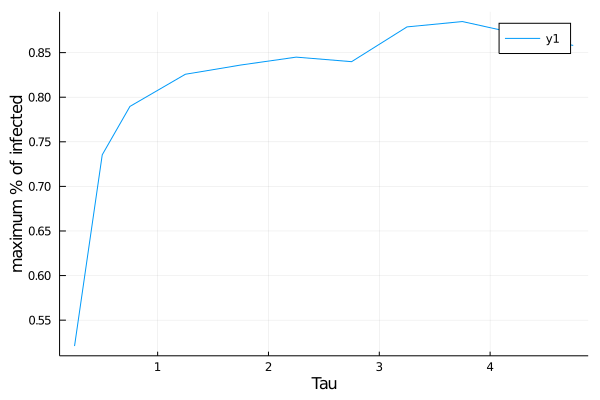

In [197]:
Plots.plot(taus10, maximum(predictions10, dims = 1)', xlabel="Tau",ylabel="maximum % of infected")

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 9 (written):</strong> Describe the figure and draw conclusions on the epidemic behavior for different degrees $d$ on regular graphs. Thus, in addition of the inner properties of the disease ($\alpha$, $\beta$, $\tau$) what other parameter is essential in the spreading ? Finally, what analogy can be done with real life from this experiment ?
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque en comparant les trois courbes que plus le nombre de dergré $k$ est grand, plus on a des infections supérieures (on peut vérifier ça en prennant n'importe quel $\tau$ comme pour $\tau$ = $1$ on a les valeurs sont $[k = 2 -> 0.3,k = 5 -> 0.71,k = 10 -> 0.82])$   et cela est raisonnable vu qu'un degré supérieur signifie plus de voisins donc plus d'infections.
    Donc on remarque qu'en addition aux paramétres ($\alpha$, $\beta$, $\tau$), le degré aussi joue un rôle important dans la propagation du virus. Cette expérience nous montre que si on veut ralentir un virus, on peut limiter les rencontres entre personne. </div>

<div style="width:75%;margin:0 auto;">

## Part 2 - SIR and SAIR model
<a id='part2'></a>
    
<p style="text-align:justify;">Unfortunately SIS model is valuable for diseases we can catch back since a cured person can get ill again. This is true for the flu, the cold, etc. However COVID-19 might create immunity for whom already got it and SIS can not take into account immune or dead persons. That is why we propose in this part to consider another model more adapted to COVID-19 called SIR. It stands for Susceptible $\rightarrow$ Infected $\rightarrow$ Recovered where the susceptible group contains those who remain susceptible to the infection, the infected group consists of those who not only have the disease but are also in the contagious period of the disease, and the recovered group contains those who were ill, got cured, are not contagious and can not get ill anymore.</p>

<br>

<p style="font-size:0.9em">M. Youssef and C. Scoglio, <cite>"An individual-based approach to SIR epidemics in contact networks"</cite>, Journal of Theoretical Biology 283 (2011)</p>

<br>
    
<p style="text-align:justify;"> One limitation of SIR is that it does not model the reaction of humans when they feel the presence of the epidemic. Indeed, if feeling threaten or surrounded by infected, an individual may change its behaviors: wear mask, wash its hands, etc. This result in a smaller infection rate. That is why in this part we will also consider a variant of SIR called SAIR which stands for Susceptible $\rightarrow$ Alert $\rightarrow$ Infected $\rightarrow$ Recovered. A susceptible individual becomes infected by the infection rate $\beta_0$, an infected individual recovers and gets immune by the curing rate $\alpha$, an individual can observe the states of its neighbors, then a susceptible individual might go to the alert state if surrounded by infected individuals with an alert rate $\kappa$ on each contact with an infected, an alert inividual becomes infected by the infection rate $\beta_1$ where $0<\beta_1<\beta_0$. In our simple SAIR model, an individual can not go back to a susceptible state when he got into the alert state.</p>
    
<br>
    
<p style="font-size:0.9em"> F. Darabi Sahneh and C. Scoglio, <cite>"Epidemic Spread in Human Networks"</cite>, 50th IEEE Conf. Decision and Contol, Orlando, Florida (2011)</p>

<div style="width:75%;margin:0 auto;">

### 2.1 SIR
    
<p style="text-align:justify;">The vector containing the disease status <code>state</code> has to change a bit since we added a new state. Hence it will be an <code>Array{Int32,1}</code> where Susceptible=0, Infected=1, and Recovered=2.</p>

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 10 (code):</strong> Implement the <code>function SIR</code> (respect the header and the specifications). You can use <code>rand</code> to translate the probabilities. Test your algorithm on <code>karat7</code>, <code>n7_2A</code>, and <code>toulouse_neigh</code> with arbitrary $\beta$, $\alpha$, and $t$. Recovered vertices should appear in a different color (<code>colorant"purple"</code>).
    
<span style="font-size:0.9em">The corrector should be able to write <code>new_state = SIR(net,state,beta,alpha,t)</code> with your code.</span>

In [198]:
function SIR(net,state,beta,alpha,t)
    """Take a contact network at a certain state and apply t time steps
    of an SIR model.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       state (Array{Int32,1}): disease status of each vertex
       beta (Float64): infection rate
       alpha (Float64): curing rate
       t (Int32): number of time step
    
    RETURNS
        (Array{Int32,1}): The new state of the contact network after t time steps.
    """
    new_state = copy(state)
    for i in 1:t
        for j in 1:nv(net)
            if state[j] == 1 
                neigh = all_neighbors(net, j)
                for ind in neigh
                    if (state[ind] == 0) 
                    r = rand()
                    if r < beta
                        new_state[ind] = 1
                    end
                    end
                end
                r = rand()
                if r < alpha
                    new_state[j] = 2
                end
            end  
        end
    end
    return new_state
end

SIR (generic function with 1 method)

In [199]:
# Test on Karat7
new_karat7_state = SIR(karat7, karat7_state, 0.3, 0.1, 10)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple"]
nodefillc = nodecolor[new_karat7_state.+1]
draw(PNG("Karat7_SIR.png", 100cm, 100cm), gplot(karat7,nodefillc=nodefillc))

In [200]:
# Test on N7_2A
new_n7_2A_state = SIR(n7_2A, n7_2A_state, 0.1, 0.3, 10)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple"]
nodefillc = nodecolor[new_n7_2A_state.+1]
draw(PNG("n7_2A_SIR.png", 100cm, 100cm), gplot(n7_2A,nodefillc=nodefillc))

In [201]:
# Test on Toulouse_neigh
new_toulouse_neigh_state = SIR(toulouse_neigh, toulouse_neigh_state, 0.1, 0.1, 100)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple"]
nodefillc = nodecolor[new_toulouse_neigh_state.+1]
draw(PNG("toulouse_neigh_SIR.png", 100cm, 100cm), gplot(toulouse_neigh,nodefillc=nodefillc))

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 11 (code):</strong> Implement the <code>function Simulation_SIR</code> (respect the header and the specifications).
    
<span style="font-size:0.9em">The corrector should be able to write <code>predictions, taus = Simulation_SIR(net,nbinf,betas,alphas,t,nbsimu)</code> with your code.</span>

In [202]:
function Simulation_SIR(net,nbinf,betas,alphas,t,nbsimu)
    """Take a contact network, different diseases (defined by 
    different parameters alpha and beta), a number of initial
    infected people and process nbsimu simulations of SIR over
    t time steps. You will provide the prediction of the 
    percentage of infected at each time t as well as the 
    spreading rate of each disease.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       nbinf (Int32): number of infected at the start of each 
            simulation
       betas (Array{Float64,1}): array of infection rate on edges
       alphas (Array{Float64,1}): array of curing rate on vertices
       t (Int32): number of time step
       nbsimu (Int32): number of simulations
    
    RETURNS
        (Array{Float64,3}): the prediction of the percentage of 
            infected, the percentage of susceptible and the 
            percentage of recovered at each time step and for each 
            disease. The first dimension contains the time steps,
            the second contains the diseases, and the third the status
            (Infected: [:,:,1], Recovered: [:,:,2], Susceptible: [:,:,3])
        (Array{Float64,1}): effective spreading rate for each 
            disease
    """
        # On infecte nbinf individus
    state = zeros(Int, nv(net))
    for i = 1:nbinf
        state[rand(1:nv(net))] = 1
    end
    
    nb_d = length(alphas)
    taus = zeros(nb_d)
    pred = zeros(t,nb_d,3)

    for l in 1:nbsimu
        for k in 1:nb_d
            # SIS
            new_state = copy(state)
            for i in 1:t
                new_state = SIR(net,new_state,betas[k],alphas[k],1)
                for j in 1:length(new_state)
                    if new_state[j] == 1
                        pred[i,k,1] = 1 / length(new_state) + pred[i,k,1] 
                    elseif new_state[j] == 2
                        pred[i,k,2] = 1 / length(new_state) + pred[i,k,2]
                    elseif new_state[j] == 0
                        pred[i,k,3] = 1 / length(new_state) + pred[i,k,3]
                    end
                end
            end
        end
    end
    for k in 1:nb_d
        for i in 1:t
            for j in 1:3
                pred[i,k,j] = pred[i,k,j] / nbsimu
            end
        end
        taus[k] = betas[k] / alphas[k]
    end
    return pred, taus
end

Simulation_SIR (generic function with 1 method)

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 12 (written):</strong> Run the script below and describe what you see. Why the infected curve does not behave the same as for SIS ? 
    
<br>

<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque de la courbe que le nombre d'infections augmente au début avec une diminution de personnes susceptibles. Après un bout de temps, le nombre de personnes qui ont guéris commence à augmenter et à un instant donné, le nombre de personnes infectés commence à diminuer et cela revient au fait que moins de gens sont sucsceptible de s'infecter. Et la courbe continue à évoluer jusqu'on arrive à un pourcentage de personnes guéris presque égal à 100% et un pourcentage de personnes infectés et susceptibles presque égal à 0%. La courbe d'infections n'est pas la même que celle du modéle $SIS$ vu que dans ce cas, une personne guéris ne peut pas s'infecter une autre fois donc le taux des infectés va diminuer à un certain moment.</div> 

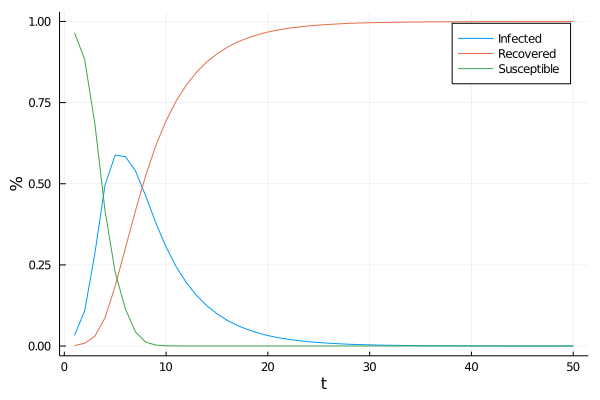

In [203]:
# Script launching prediction on one disease on n7_2A and plotting the percentage
# of infected, susceptible and recovered at each time step.
predictions, taus = Simulation_SIR(n7_2A,2,[0.3],[0.2],50,1000)

Plots.plot([predictions[:,:,1] predictions[:,:,2] predictions[:,:,3]],
           label=["Infected" "Recovered" "Susceptible"],xlabel="t",ylabel="%")

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 13 (written):</strong> As for Question 6 script 2 plot the evolution of the percentage of infected for many $\tau$. Describe what you see.
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque que le pourcentage d'infectés augmente et diminue aprés un moment. On remarque aussi que plus $\tau$ est grand, plus on a un pic de pourcentage d'infections grand (on peut prendre l'exemple de $0.65$ pour $\tau = 4.74$ et $0.1$ pour $\tau = 0.5$) . </div>

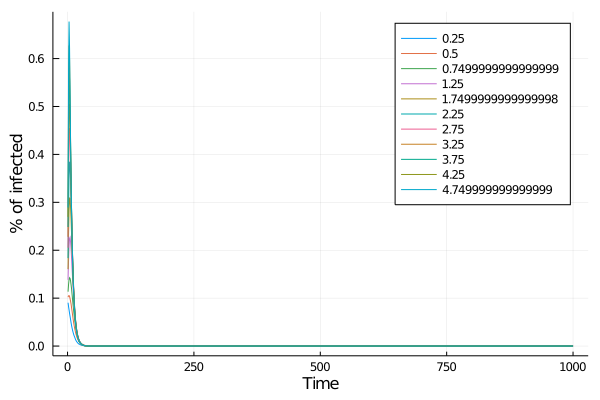

In [204]:
# Equivalent experiment as for Question 6 script 2
betas = [0.05,0.1,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
alphas = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]

predictions, taus = Simulation_SIR(toulouse_neigh,100,betas,alphas,1000,100)

Plots.plot(predictions[:,:,1], label=taus',xlabel="Time",ylabel="% of infected")

<div style="width:75%;margin:0 auto;">

<strong style="color:cornflowerblue">Question 14 (code):</strong> Implement a script plotting the number of infected over 75 time steps for $\beta=0.3$ and $\alpha=0.2$ fixed and on 3 contact networks:
    
* A regular graph of 200 vertices with degree 2.
* A regular graph of 200 vertices with degree 5.
* A regular graph of 200 vertices with degree 10.
    

In [205]:
# Plots of the number of infected people according to tau over 75 time 
# steps for 3 contact networks.
G2 = random_regular_graph(200,2)
G5 = random_regular_graph(200,5)
G10 = random_regular_graph(200,10)
betas = [0.3]
alphas = [0.2]
predictions2, taus2 = Simulation_SIR(G2,3,betas,alphas,75,100)
predictions5, taus5 = Simulation_SIR(G5,3,betas,alphas,75,100)
predictions10, taus10 = Simulation_SIR(G10,3,betas,alphas,75,100)

([0.05714999999999901; 0.17640000000000775; … ; 0.0; 0.0]

[0.0029000000000000015; 0.014449999999999913; … ; 0.9999999999998154; 0.9999999999998154]

[0.9399499999998701; 0.8091499999999889; … ; 0.0; 0.0], [1.4999999999999998])

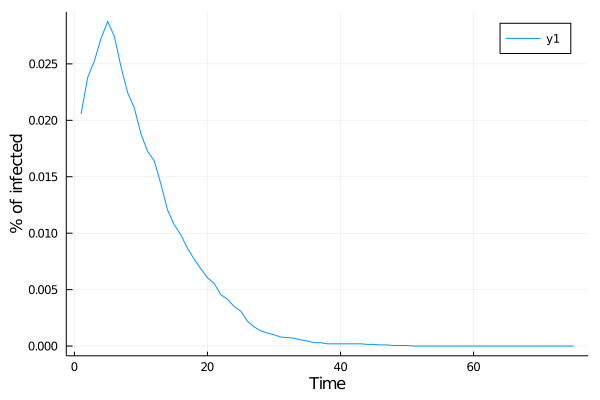

In [206]:
Plots.plot(predictions2[:,:,1], xlabel="Time",ylabel="% of infected")

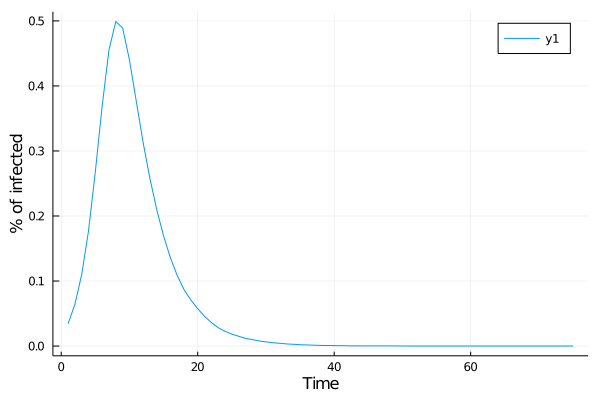

In [207]:
Plots.plot(predictions5[:,:,1], xlabel="Time",ylabel="% of infected")

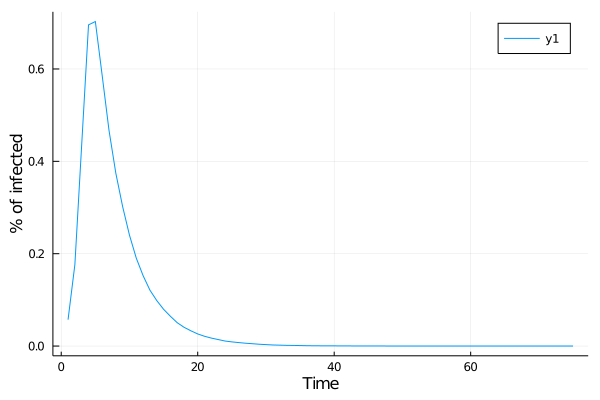

In [208]:
Plots.plot(predictions10[:,:,1], xlabel="Time",ylabel="% of infected")

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 15 (written):</strong> From the previous figure, explain why lockdown can be interesting when hospital places are lacking ?

<br>

<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque des courbes qu'un degré grand nous donne un pic de personnes infectés plus grand ($d -> 2$ : $0.027$, $d -> 5$ : $0.52$ et $d -> 10$ : $0.69$ . Si les hopitaux ne peuvent pas prendre des gens infectés, ces derniers vont avoir plus de contacts dans le monde extérieur (dans notre cas c'est le degré qui augmente) donc plus de gens vont être infectés. Donc un confinement pour limiter les contacts est une solution interessante. </div>

<div style="width:75%;margin:0 auto;">

### 2.2 SAIR
    
<p style="text-align:justify;">The vector containing the disease status <code>state</code> has to change a bit since we added a new state. Hence it will be an <code>Array{Int32,1}</code> where Susceptible=0, Infected=1, Recovered=2, and Alert=3.</p>

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 16 (code):</strong> Implement the <code>function SAIR</code> (respect the header and the specifications). You can use <code>rand</code> to translate the probabilities. Test your algorithm on <code>karat7</code>, <code>n7_2A</code>, and <code>toulouse_neigh</code> with arbitrary $\beta$, $\alpha$, and $t$. Alerted vertices should appear in a different color (<code>colorant"lightgreen"</code>).
    
<span style="font-size:0.9em">The corrector should be able to write <code>new_state = SAIR(net,state,beta0,beta1,alpha,kappa,t)</code> with your code.</span>

In [209]:
function SAIR(net,state,beta0,beta1,alpha,kappa,t)
    """Take a contact network at a certain state and apply t time steps
    of an SAIR model.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       state (Array{Int32,1}): disease status of each vertex
       beta0 (Float64): infection rate when not alert
       beta1 (Float64): infection rate when alert
       alpha (Float64): curing rate
       kappa (Float64): alerting rate
       t (Int32): number of time step
    
    RETURNS
        (Array{Int32,1}): The new state of the contact network after t time steps.
    """      
    new_state = copy(state)
    for i in 1:t
        for j in 1:nv(net)
            if state[j] == 1 
                neigh = all_neighbors(net, j)
                for ind in neigh
                    if (state[ind] == 0) 
                        r = rand()
                        rr = rand()
                        if r < beta0
                            new_state[ind] = 1
                        elseif rr < kappa 
                            new_state[ind] = 3
                        end
                    elseif (state[ind] == 3)
                        r = rand()
                        if r < beta1
                            new_state[ind] = 1
                        end
                    end
                end
                r = rand()
                if r < alpha
                    new_state[j] = 2
                end
            end  
        end
    end
    return new_state
end

SAIR (generic function with 1 method)

In [210]:
# Test on Karat7
new_karat7_state = SAIR(karat7, karat7_state, 0.3 ,0.25 ,0.3, 0.1, 10)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple", colorant"lightgreen"]
nodefillc = nodecolor[new_karat7_state.+1]
draw(PNG("Karat7_SAIR.png", 100cm, 100cm), gplot(karat7,nodefillc=nodefillc))

In [211]:
# Test on N7_2A
new_n7_2A_state = SAIR(n7_2A, n7_2A_state,0.3,0.25, 0.1, 0.3, 10)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple", colorant"lightgreen"]
nodefillc = nodecolor[new_n7_2A_state.+1]
draw(PNG("n7_2A_SAIR.png", 100cm, 100cm), gplot(n7_2A,nodefillc=nodefillc))

In [212]:
# Test on Toulouse_neigh
new_toulouse_neigh_state = SAIR(toulouse_neigh, toulouse_neigh_state,0.3,0.25, 0.1, 0.3, 10)
nodecolor = [colorant"lightseagreen", colorant"orange" , colorant"purple", colorant"lightgreen"]
nodefillc = nodecolor[new_toulouse_neigh_state.+1]
draw(PNG("toulouse_neigh_SAIR.png", 100cm, 100cm), gplot(toulouse_neigh,nodefillc=nodefillc))

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 17 (code):</strong> Implement the <code>function Simulation_SAIR</code> (respect the header and the specifications).
    
<span style="font-size:0.9em">The corrector should be able to write <code>predictions, taus = Simulation_SAIR(net,nbinf,betas0,betas1,alphas,kappas,t,nbsimu)</code> with your code.</span>

In [213]:
function Simulation_SAIR(net,nbinf,betas0,betas1,alphas,kappas,t,nbsimu)
    """Take a contact network, different diseases (defined by 
    different parameters alpha and beta), a number of initial
    infected people and process nbsimu simulations of SAIR over
    t time steps. You will provide the prediction of the 
    percentage of infected at each time t as well as the 
    spreading rate of each disease.
    
    PARAMS
       net (LightGraph): graph representing the contact network
       nbinf (Int32): number of infected at the start of each 
            simulation
       betas0 (Array{Float64,1}): array of infection rate when not alert on edges
       betas1 (Array{Float64,1}): array of infection rate when alert on edges
       alphas (Array{Float64,1}): array of curing rate on vertices
       kappas (Array{Float64,1}): array of alerting rate on edges
       t (Int32): number of time step
       nbsimu (Int32): number of simulations
    
    RETURNS
        (Array{Float64,3}): the prediction of the percentage of 
            infected, the percentage of susceptible and the 
            percentage of recovered at each time step and for each 
            disease. The first dimension contains the time steps,
            the second contains the diseases, and the third the status
            (Infected: [:,:,1], Recovered: [:,:,2], Susceptible: [:,:,3])
        (Array{Float64,1}): effective spreading rate for each 
            disease
    """
    state = zeros(Int, nv(net))
    for i = 1:nbinf
        state[rand(1:nv(net))] = 1
    end
    
    nb_d = length(alphas)
    taus = zeros(nb_d)
    pred = zeros(t,nb_d,3)

    for l in 1:nbsimu
        for k in 1:nb_d
            new_state = copy(state)
            for i in 1:t
                new_state = SAIR(net,new_state,betas0[k],betas1[k],alphas[k],kappas[k],1)
                for j in 1:length(new_state)
                    if new_state[j] == 0 || new_state[j] == 3
                        pred[i,k,3] = 1 / length(new_state) + pred[i,k,3] 
                    elseif new_state[j] == 2
                        pred[i,k,2] = 1 / length(new_state) + pred[i,k,2]
                    elseif new_state[j] == 1
                        pred[i,k,1] = 1 / length(new_state) + pred[i,k,1]
                    end
                end
            end
        end
    end
    for k in 1:nb_d
        for i in 1:t
            for j in 1:3
                pred[i,k,j] = pred[i,k,j] / nbsimu
            end
        end
        taus[k] = betas0[k] / alphas[k]
    end
    return pred, taus
end

Simulation_SAIR (generic function with 1 method)

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 18 (written):</strong> Run the script below comparing the number of infected of SAIR and SIR and comment what you see.
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> On remarque que le pic de pourcentage d'infection est inférieur dans le cas $SAIR$. Et ceci est normal vu que dans $SAIR$, on a ajouté un état alerte qui représente un malade qui ne peut pas encore infecter les gens et dans $SIR$ il pouvait infecter. </div>

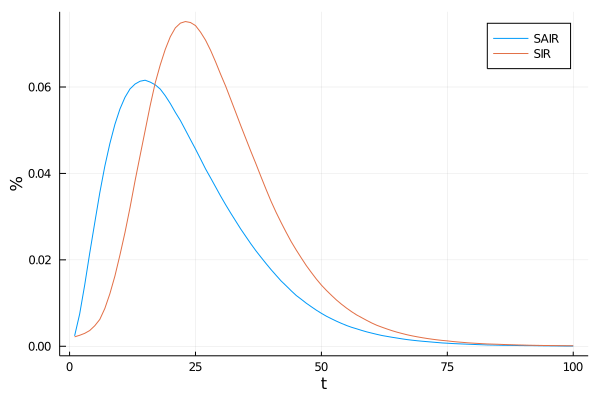

In [214]:
# Script launching prediction on one disease on toulouse_neigh and plotting the percentage
# of infected at each time step for SIR and SAIR.
predictions1, taus1 = Simulation_SAIR(toulouse_neigh,2,[0.2],[0.1],[0.1],[0.4],100,1000)
predictions2, taus2 = Simulation_SIR(toulouse_neigh,2,[0.2],[0.1],100,1000)

Plots.plot([predictions1[:,:,1] predictions2[:,:,1]],
           label=["SAIR" "SIR"],xlabel="t",ylabel="%")

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 19 (written):</strong> Of course the presented SIS, SIR, and SAIR models are limitated in their modelization of the reality. Formulate few of these limitations (at least 2). 
Propose few algorithm addons/ideas (at least 2) which would make the models more complex and more accurate in regards to the reality.
    
<br>
    
<div style="background-color:#E7F1D1"> <strong>Answer:</strong> Les limitations qui se présentent sur ces modéles sont:<br>
 . Si on prend l'exemple du COVID-19, on a des patients qui n'ont pas eu l'immunité du virus et sont tombés malades deux fois.<br>
 . On n'a pas traiter le cas de mortalité du virus. Si un virus est mortel, ces modéles ne traitent pas les morts et ils restent considérés comme infectés.<br>
 . On peu atteindre une immunité collective donc on aura plus d'infections.
<br>
On pourrait ajouter des choses pour ameliorer nos modéles comme:<br>
 . Un taux de mortalité et un cas dans le state == 4.<br>
 . Un taux de notRecovered(très petit) qui représente le cas où une personne peut retomber malade.</div>

<div style="width:75%;margin:0 auto;">

## Part 3 - Discover patient zero
    
<p style="text-align:justify;"> In the two previous parts you may have realised that understanding and controlling the spread of epidemics on contact networks is an important task. However, information about
the origin of the epidemic could be also extremely useful to reduce or prevent future outbreaks. Thus, in this part we will focus on algorithm solutions to answer this issue.</p>
    
<p style="text-align:justify;"> The stochastic nature of infection propagation makes the estimation of the epidemic origin intrinsically hard: indeed, different initial conditions can lead to the same configuration at the observation time. Methods such as the distance centrality or the Jordan center try to approximate it. They both rely on spatial information by stating that the first infected is probably at the center of the cluster of infection. Mathematically:
    
* The jordan center is expressed as $\min_{v\in \mathcal{I}}\max_{n\in \mathcal{I}}d(v,n)$ where $\mathcal{I}$ is a connected component of the original contact network containing all infected and recovered vertices, and where $d(\cdot,\cdot)$ is the distance (= the shortest path) between 2 vertices (if not weighted graph each edge accounts for 1 unit). 
* The distance centrality is expressed as $\min_{v\in \mathcal{I}}\sum_{n\in \mathcal{I}}d(v,n)(\delta_{n,I} + \delta_{n,R}/\alpha)$, where $\delta_{n,I}=1$ if the vertex n is infected ($=0$ otherwise), and where $\delta_{n,R}=1$ if the vertex n is recovered ($=0$ otherwise). You may note that in distance centrality we increase the weight of the recovered vertices by a factor $1/\alpha$, it translates the fact that recovered vertices tend to be closer to the origin of the epidemic since they probably got ill before.
    
    
We formulate the problem as follow: given a contact network and a snapshot of epidemic spread at a certain time, determine the infection source. A snapshot is a given <code>state</code> array for a contact network.</p>

<br>
    
<p style="font-size:0.9em"> A. Y. Lokhov, M. Mézard, H. Ohta, and L. Zdeborová, <cite>"Inferring the origin of an epidemic with a dynamic message-passing algorithm"</cite>, Physical Review (2014)</p>

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 20 (code):</strong> Implement the <code>function jordan</code> (respect the header and the specifications). You will need to use the function <code>dijkstra_shortest_paths</code> of the LighGraphs library, refer to the doc for more information. If there are multiple minimal vertices, then return the first one.
    
<span style="font-size:0.9em">The corrector should be able to write <code>zero = jordan(g,state,alpha)</code> with your code.</span>

In [215]:
function jordan(g,state)
    """Find patient zero by mean of the jordan center method.
    
    PARAMS
        g (LightGraph): graph representing the contact network
        state (Array{Int32,1}): disease status of each vertex
    
    RETURNS
        (Int32): the patient zero vertex number 
    """
    nbv = nv(g)
    tab_max_dis = zeros(nbv)
    
    for i in 1:nbv
        if state[i] == 1 || state[i] == 2
            for j in 1:nbv
                if state[j] == 1 || state[j] == 2
                    if (tab_max_dis[i] < dijkstra_shortest_paths(g, i).dists[j])
                        tab_max_dis[i] = dijkstra_shortest_paths(g, i).dists[j]
                    end
                end
            end
        end
    end
    
    indice_min = 1
    min = tab_max_dis[1]
    for i in 1:nbv
        if tab_max_dis[i] > 0 && (tab_max_dis[i] < min || min == 0)
           indice_min = i
           min = tab_max_dis[i]
        end
    end
    return indice_min
end

jordan (generic function with 1 method)

<div style="width:75%;margin:0 auto;">
    
<strong style="color:cornflowerblue">Question 21 (code):</strong> Implement the <code>function distance</code> (respect the header and the specifications). You will need to use the function <code>dijkstra_shortest_paths</code> of the LighGraphs library, refer to the doc for more information. If there are multiple minimal vertices, then return the first one.
    
<span style="font-size:0.9em">The corrector should be able to write <code>zero = distance(g,state,alpha)</code> with your code.</span>

In [216]:
function distance(g,state,alpha=1.)
    """Find patient zero by mean of the distance centrality method.
    
    PARAMS
        g (LightGraph): graph representing the contact network
        state (Array{Int32,1}): disease status of each vertex
        alpha (Float64): curing rate
    
    RETURNS
        (Int32): the patient zero vertex number 
    """
    nbv = nv(g)
    tab_somme_dis = zeros(nbv)
    
     for i in 1:nbv
        if state[i] == 1 || state[i] == 2
            for j in 1:nbv
                if state[j] == 1
                    tab_somme_dis[i] = tab_somme_dis[i] + dijkstra_shortest_paths(g, i).dists[j]
                elseif state[j] == 2
                    tab_somme_dis[i] = tab_somme_dis[i] + (dijkstra_shortest_paths(g, i).dists[j])/alpha
                end
            end
        end
    end
    
    indice_min = 1
    min = tab_somme_dis[1]
    for i in 1:nbv
        if tab_somme_dis[i] > 0 && (tab_somme_dis[i] < min || min == 0)
           indice_min = i
           min = tab_somme_dis[i]
        end
    end
    return indice_min
end

distance (generic function with 2 methods)

<div style="width:75%;margin:0 auto;">

<strong style="color:cadetblue">Question 22 (written):</strong> Run the 3 following scripts using your functions <code>jordan</code> and <code>distance</code> and comment on the results.
    
The contact network is karat7 for 2 different patient zero and a $50\times 50$ grid. The real patient zero ("Z"), your jordan ("J") and distance ("D") approximations are appearing in <code>colorant"lightblue"</code>.
    
<br>
    
<div style="background-color:#E7F1D1"> <strong> Answer:</strong> Pour le premier exemple, l'approximation avec les deux  est correcte. Pour le deuxième, nos approximations avec les algorithmes jordan et distance sont adjacents avec le partient zéro. Et pour le dernier exemple, l'approximation reste proche (J est à 4 arêtes de Z et C est à 3 arêtes de Z). On remarque que plus le graphe est grand, plus l'approximation devient imprécise. </div>

In [217]:
# Loading a snapshot of karat7
@load "karat7_Q22_1.jld2" g state pat_zero alpha beta loc_x loc_y

# Run the patient zero finding function
cent_pat_zero = distance(g,state,alpha)
jor_pat_zero = jordan(g,state)

# Some display options 
labels = Array{String, 1}(undef,nv(g))
for k=1:nv(g)
    if state[k]==1
        labels[k]="I"
    elseif state[k]==2
        labels[k]="R"
    else
        labels[k]="S"
    end
end

if cent_pat_zero==jor_pat_zero==pat_zero
    labels[cent_pat_zero]="C+J+Z"
elseif cent_pat_zero==jor_pat_zero
    labels[cent_pat_zero]="C+J"
    labels[pat_zero]="Z"
elseif cent_pat_zero==pat_zero
    labels[cent_pat_zero]="C+Z"
    labels[jor_pat_zero]="J"
elseif jor_pat_zero==pat_zero
    labels[jor_pat_zero]="J+Z"
    labels[cent_pat_zero]="C"
else
    labels[cent_pat_zero]="C"
    labels[jor_pat_zero]="J"
    labels[pat_zero]="Z"
end

nodecolor = [colorant"lightseagreen", colorant"orange", colorant"purple"]
colors = nodecolor[state + ones(Int32,nv(g))]
colors[pat_zero] = colorant"lightblue"
colors[cent_pat_zero] = colorant"lightblue"
colors[jor_pat_zero] = colorant"lightblue"

# Display
draw(PNG("karat7_Q22_1.png", 20cm, 20cm), gplot(g,loc_x,loc_y,nodefillc=colors,nodelabel=labels))

In [218]:
# Loading a snapshot of karat7
@load "karat7_Q22_2.jld2" g state pat_zero alpha beta loc_x loc_y

# Run the patient zero finding function
cent_pat_zero = distance(g,state,alpha)
jor_pat_zero = jordan(g,state)

# Some display options 
labels = Array{String, 1}(undef,nv(g))
for k=1:nv(g)
    if state[k]==1
        labels[k]="I"
    elseif state[k]==2
        labels[k]="R"
    else
        labels[k]="S"
    end
end

if cent_pat_zero==jor_pat_zero==pat_zero
    labels[cent_pat_zero]="C+J+Z"
elseif cent_pat_zero==jor_pat_zero
    labels[cent_pat_zero]="C+J"
    labels[pat_zero]="Z"
elseif cent_pat_zero==pat_zero
    labels[cent_pat_zero]="C+Z"
    labels[jor_pat_zero]="J"
elseif jor_pat_zero==pat_zero
    labels[jor_pat_zero]="J+Z"
    labels[cent_pat_zero]="C"
else
    labels[cent_pat_zero]="C"
    labels[jor_pat_zero]="J"
    labels[pat_zero]="Z"
end

nodecolor = [colorant"lightseagreen", colorant"orange", colorant"purple"]
colors = nodecolor[state + ones(Int32,nv(g))]
colors[pat_zero] = colorant"lightblue"
colors[cent_pat_zero] = colorant"lightblue"
colors[jor_pat_zero] = colorant"lightblue"

# Display
draw(PNG("karat7_Q22_2.png", 20cm, 20cm), gplot(g,loc_x,loc_y,nodefillc=colors,nodelabel=labels))

In [219]:
# Loading a snapshot of grid50
@load "grid50_Q22.jld2" g state pat_zero alpha beta loc_x loc_y

# Run the patient zero finding function
cent_pat_zero = distance(g,state,alpha)
jor_pat_zero = jordan(g,state)

# Some display options 
labels = Array{String, 1}(undef,nv(g))
for k=1:nv(g)
    if state[k]==1
        labels[k]="I"
    elseif state[k]==2
        labels[k]="R"
    else
        labels[k]="S"
    end
end

if cent_pat_zero==jor_pat_zero==pat_zero
    labels[cent_pat_zero]="C+J+Z"
elseif cent_pat_zero==jor_pat_zero
    labels[cent_pat_zero]="C+J"
    labels[pat_zero]="Z"
elseif cent_pat_zero==pat_zero
    labels[cent_pat_zero]="C+Z"
    labels[jor_pat_zero]="J"
elseif jor_pat_zero==pat_zero
    labels[jor_pat_zero]="J+Z"
    labels[cent_pat_zero]="C"
else
    labels[cent_pat_zero]="C"
    labels[jor_pat_zero]="J"
    labels[pat_zero]="Z"
end

nodecolor = [colorant"lightseagreen", colorant"orange", colorant"purple"]
colors = nodecolor[state + ones(Int32,nv(g))]
colors[pat_zero] = colorant"lightblue"
colors[cent_pat_zero] = colorant"lightblue"
colors[jor_pat_zero] = colorant"lightblue"

# Display
draw(PNG("grid50_Q22.png", 100cm, 100cm), gplot(g,loc_x,loc_y,nodefillc=colors,nodelabel=labels))